In [1]:
# Imports
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Load the .mat file
data = scipy.io.loadmat('data/condsForSimJ2moMuscles.mat')

# Extract condsForSim struct
conds_for_sim = data['condsForSim']

In [3]:
# Initialize lists to store data for all conditions
go_envelope_all = []
plan_all = []
muscle_all = []

# Get the number of conditions (rows) and delay durations (columns)
num_conditions, num_delays = conds_for_sim.shape

# Loop through each condition and extract data
for i in range(num_conditions):  # 27 conditions
    go_envelope_condition = []
    plan_condition = []
    muscle_condition = []

    for j in range(num_delays):  # 8 delay durations
        condition = conds_for_sim[i, j]

        go_envelope = condition['goEnvelope']
        plan = condition['plan']
        muscle = condition['muscle']

        # Select only muscles 5 and 6 
        selected_muscle_data = muscle[:, [4, 5]]  # Select columns for muscle 5 and 6, which show the nicest multiphasic activity

        go_envelope_condition.append(go_envelope)
        plan_condition.append(plan)
        muscle_condition.append(selected_muscle_data)

    # Stack data for each condition
    go_envelope_all.append(torch.tensor(go_envelope_condition, dtype=torch.float32))
    plan_all.append(torch.tensor(plan_condition, dtype=torch.float32))
    muscle_all.append(torch.tensor(muscle_condition, dtype=torch.float32))

# Stack data for all conditions
go_envelope_tensor = torch.stack(go_envelope_all)
plan_tensor = torch.stack(plan_all)
muscle_tensor = torch.stack(muscle_all)

# Reshape to merge the first two dimensions
go_envelope_tensor = go_envelope_tensor.reshape(-1, *go_envelope_tensor.shape[2:])
plan_tensor = plan_tensor.reshape(-1, *plan_tensor.shape[2:])
muscle_tensor = muscle_tensor.reshape(-1, *muscle_tensor.shape[2:])

# Print shapes
print(f"Go Envelope Tensor Shape: {go_envelope_tensor.shape}")
print(f"Plan Tensor Shape: {plan_tensor.shape}")
print(f"Muscle Tensor Shape: {muscle_tensor.shape}")


Go Envelope Tensor Shape: torch.Size([216, 296, 1])
Plan Tensor Shape: torch.Size([216, 296, 15])
Muscle Tensor Shape: torch.Size([216, 296, 2])


/tmp/ipykernel_365243/1417502240.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  go_envelope_all.append(torch.tensor(go_envelope_condition, dtype=torch.float32))


In [4]:
# Normalize and standardize a tensor
def normalize_and_standardize(tensor):
    # Normalize: Scale to 0-1 range
    min_val = tensor.min()
    max_val = tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)

    # Standardize: Shift to zero mean and unit variance
    mean = tensor.mean()
    std = tensor.std()
    tensor = (tensor - mean) / std

    return tensor

# Apply the function to each tensor
normalized_go_envelope_tensor = normalize_and_standardize(go_envelope_tensor)
normalized_plan_tensor = normalize_and_standardize(plan_tensor)
normalized_muscle_tensor = normalize_and_standardize(muscle_tensor)

# Print shapes to confirm
print(f"Normalized Go Envelope Tensor Shape: {normalized_go_envelope_tensor.shape}")
print(f"Normalized Plan Tensor Shape: {normalized_plan_tensor.shape}")
print(f"Normalized Muscle Tensor Shape: {normalized_muscle_tensor.shape}")


Normalized Go Envelope Tensor Shape: torch.Size([216, 296, 1])
Normalized Plan Tensor Shape: torch.Size([216, 296, 15])
Normalized Muscle Tensor Shape: torch.Size([216, 296, 2])


In [5]:
import torch
import torch.nn as nn

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, x, torch.tanh(x))
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)  # New linear layer

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh    
        
    def forward(self, x, hidden):
        hidden_prev = hidden.clone()
        timestep = self.tau / 10  # Timestep for Euler integration

        # Update hidden state
        hidden_update = torch.matmul(self.J, hidden.transpose(0, 1))
        input_update = torch.matmul(self.B, x.transpose(0, 1))
        new_hidden = self.nonlinearity(hidden_update + input_update + self.bx.unsqueeze(1))
        new_hidden = new_hidden.transpose(0, 1)

        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden + new_hidden)

        # Output calculation
        output = self.output_linear(hidden)

        # Regularization terms
        firing_rate_reg = hidden.pow(2).sum()
        dynamic_reg = (hidden - hidden_prev).pow(2).sum().sqrt()

        return output, hidden, firing_rate_reg, dynamic_reg

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

# Hyperparameters
input_size = 16
hidden_size = 300
output_size = 2  # Number of muscles
g = 1.5  # g value
h = 1.0  # h value

# Model instantiation
model = SimpleRNN(input_size, hidden_size, output_size, g, h)


In [6]:
import torch
import torch.nn as nn

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, x, torch.tanh(x))
    
class ComplicatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(ComplicatedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant

        # Modified weight initialization for a more chaotic regime (g >> 1)
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float))))
        self.w = nn.Parameter(torch.zeros(output_size, hidden_size))
        self.bx = nn.Parameter(torch.zeros(hidden_size))
        self.bz = nn.Parameter(torch.zeros(output_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh    
    
    def forward(self, x, hidden):
        timestep = self.tau / 10  # Timestep for Euler integration
        for _ in range(int(1 / timestep)):  # Adjust the range for simulation duration
            hidden_update = torch.matmul(self.J, hidden.T)
            input_update = torch.matmul(self.B, x.T)
            new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)  
            new_hidden = new_hidden.T
    
            # Euler integration for continuous-time update
            hidden = hidden + (timestep / self.tau) * (-hidden + new_hidden)
        
        output = torch.matmul(self.w, hidden.T) + self.bz.unsqueeze(1)
        output = output.T
    
        return output, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

input_size = 16
hidden_size = 300
output_size = 2 # Number of muscles
g = 4 # Significantly larger g value for complicated model
h = 1.0 # h value remains the same

complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h)

In [7]:
# Convert datasets to TensorDataset and DataLoader for batch processing
from torch.utils.data import TensorDataset, DataLoader

# Concatenate along the third dimension (dim=2)
X_train = torch.cat((normalized_go_envelope_tensor, normalized_plan_tensor), dim=2)

# y_train remains the same
y_train = normalized_muscle_tensor

batch_size = 64  # You can adjust this based on your data size and memory constraints
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [8]:
# Loss Function and Optimizer
criterion = nn.MSELoss()  # MSE Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg


Epoch 1, Loss: 177.55069732666016
Epoch 2, Loss: 143.13556385040283
Epoch 3, Loss: 126.14177799224854
Epoch 4, Loss: 113.30393981933594
Epoch 5, Loss: 103.33582019805908
Epoch 6, Loss: 96.83152675628662
Epoch 7, Loss: 91.44083023071289
Epoch 8, Loss: 86.95909214019775
Epoch 9, Loss: 83.11252498626709
Epoch 10, Loss: 79.76173496246338
Epoch 11, Loss: 76.71908855438232
Epoch 12, Loss: 73.89816284179688
Epoch 13, Loss: 71.30599641799927
Epoch 14, Loss: 68.92754077911377
Epoch 15, Loss: 66.67179250717163
Epoch 16, Loss: 64.58552312850952
Epoch 17, Loss: 62.599005699157715
Epoch 18, Loss: 60.701364517211914
Epoch 19, Loss: 58.88544988632202
Epoch 20, Loss: 57.18330383300781
Epoch 21, Loss: 55.553619384765625
Epoch 22, Loss: 53.9784197807312
Epoch 23, Loss: 52.502137660980225
Epoch 24, Loss: 51.07646465301514
Epoch 25, Loss: 49.72431802749634
Epoch 26, Loss: 48.405807971954346
Epoch 27, Loss: 47.16712760925293
Epoch 28, Loss: 45.981868743896484
Epoch 29, Loss: 44.84423589706421
Epoch 30, Los

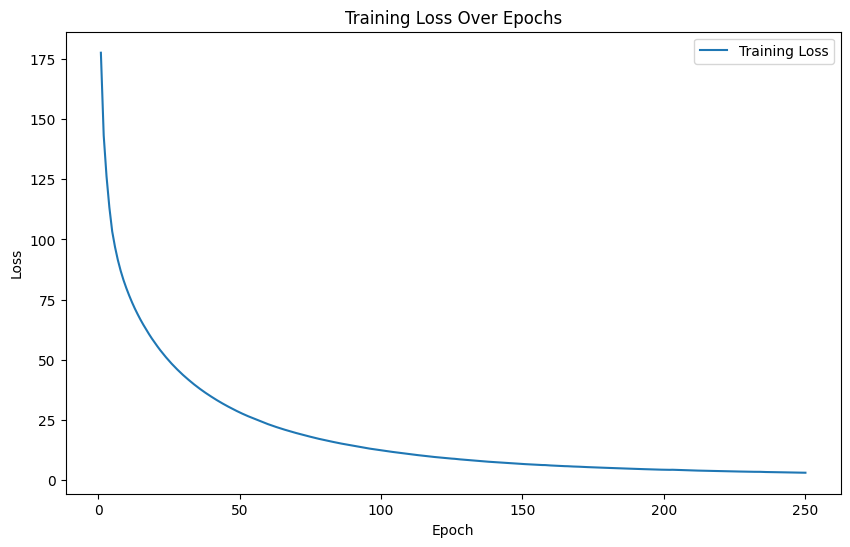

In [10]:
import matplotlib.pyplot as plt

# Hyperparameters for regularization
alpha = 1e-4  # Example value, adjust as necessary
beta = 0.03
gamma = 1e-4

# Training Loop
num_epochs = 250  # The number of times the entire dataset is passed through the network
epoch_losses = []  # List to store average loss of each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        batch_size = inputs.size(0)
        h = model.init_hidden(batch_size) # Initialize hidden state with the current batch size
        optimizer.zero_grad()

        total_firing_rate_reg = 0
        total_dynamic_reg = 0

        # Process each time step in the inputs
        for t in range(inputs.shape[1]):
            output, h, firing_rate_reg, dynamic_reg = model(inputs[:, t, :], h)
            total_firing_rate_reg += firing_rate_reg
            total_dynamic_reg += dynamic_reg
    
        # Compute loss using the last output and include regularization terms:
        loss = criterion(output, targets[:, -1, :])
        l2_reg = compute_l2_regularization(model.parameters(), alpha)
        rfr_reg = beta * total_firing_rate_reg / inputs.shape[1]  # Average over time steps
        rj_reg = gamma * total_dynamic_reg / inputs.shape[1]  # Average over time steps
    
        total_loss = loss + l2_reg + rfr_reg + rj_reg
        total_loss.backward()
        optimizer.step()
    
        running_loss += total_loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

print('Finished Training')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


Epoch 1, Loss: 0.6549973413348198
Epoch 2, Loss: 0.8258856683969498
Epoch 3, Loss: 0.7035587280988693
Epoch 4, Loss: 0.6584394052624702
Epoch 5, Loss: 0.6550970450043678
Epoch 6, Loss: 0.8330420702695847
Epoch 7, Loss: 0.7133725434541702
Epoch 8, Loss: 0.7909747362136841
Epoch 9, Loss: 0.6953021362423897
Epoch 10, Loss: 0.7020393460988998
Epoch 11, Loss: 0.7031993567943573
Epoch 12, Loss: 0.6886653304100037
Epoch 13, Loss: 0.7300060093402863
Epoch 14, Loss: 0.6608780100941658
Epoch 15, Loss: 0.7608095556497574
Epoch 16, Loss: 0.7276464998722076
Epoch 17, Loss: 0.6995602995157242
Epoch 18, Loss: 0.7344301044940948
Epoch 19, Loss: 0.7695096284151077
Epoch 20, Loss: 0.6624482572078705
Epoch 21, Loss: 0.7329000532627106
Epoch 22, Loss: 0.7334881573915482
Epoch 23, Loss: 0.6816388592123985
Epoch 24, Loss: 0.7334701642394066
Epoch 25, Loss: 0.68792924284935
Epoch 26, Loss: 0.6733858436346054
Epoch 27, Loss: 0.7288410514593124
Epoch 28, Loss: 0.68007542937994
Epoch 29, Loss: 0.723496437072753

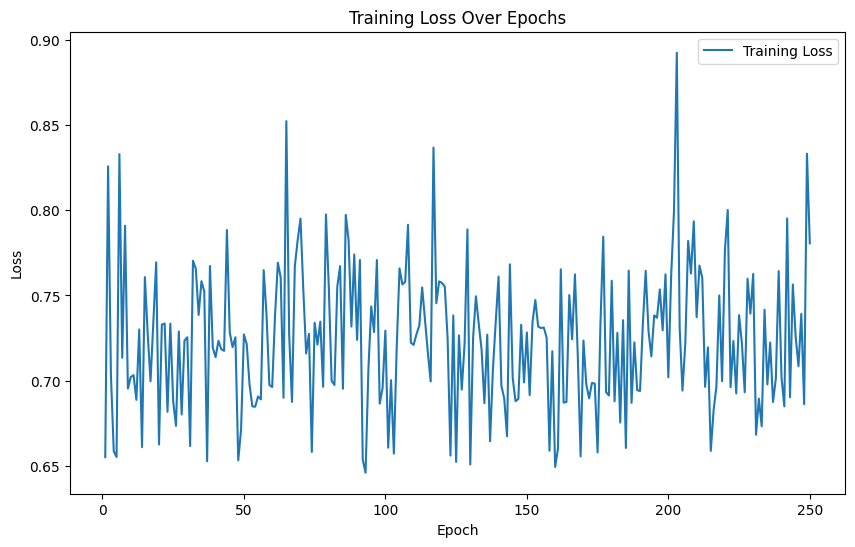

In [13]:
import matplotlib.pyplot as plt

# Training Loop
num_epochs = 250  # The number of times the entire dataset is passed through the network
epoch_losses = []  # List to store average loss of each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        batch_size = inputs.size(0)
        h = model.init_hidden(batch_size) # Initialize hidden state with the current batch size

        # Process each time step
        for t in range(inputs.shape[1]):  # iterate over time steps
            output, h = complicated_model(inputs[:, t, :], h)

        # Compute loss using the last output (if your task is many-to-one)
        loss = criterion(output, targets[:, -1, :])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

print('Finished Training')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()